# COMSW4995_007_2021_3 NNDL - Tutorial 2

## Tutorial overview

- Introduction to interactive notebooks

- Introduction to Autograd and PyTorch

- Walk-through several PyTorch models (with increasing levels of complexity and abstraction)

## Interactive notebooks

### Overview

- Keep documentation, code, and outputs in the same file.

- Many different implementations (e.g. Jupyter, Google Colab, Zeppelin, etc.)

- Many different languages (e.g. Python, C++ (xeus), Scala, etc.)

### Jupyter notebooks / lab

-

### Google Colab

- Hosted interactive notebooks (similar to Jupyter notebooks).

- Can get a free GPU or TPU (for at most 12 hours...).

- (Note to self:) Make sure to select a runtime with a GPU.

## Automatic differentiation

References:

- Ryan Adams' talk: https://www.youtube.com/watch?v=sq2gPzlrM0g
- Backpropagation notes from Stanford's CS231n: http://cs231n.github.io/optimization-2/
- Autograd Github Repository (contains a tutorial and examples): https://github.com/HIPS/autograd

### Approaches for Computing Derivatives

- **Symbolic differentiation:** automatic manipulation of mathematical expressions to get derivatives
    - Takes a math expression and returns a math expression: $f(x) = x^2 \rightarrow \frac{df(x)}{dx} = 2x$
    - Used in Mathematica, Maple, SymPy, etc.

- **Numeric differentiation:** Approximating derivatives by finite differences:
$$
\frac{\partial}{\partial x_i} f(x_1, \dots, x_N) = \lim_{h \to 0} \frac{f(x_1, \dots, x_i + h, \dots, x_N) - f(x_1, \dots, x_i - h, \dots, x_N)}{2h}
$$

- **Automatic differentiation:** Takes code that computes a function and returns code that computes the derivative of that function.
    - Reverse Mode AD: A method to get exact derivatives efficiently, by storing information as you go forward that you can reuse as you go backwards

    - **PyTorch**, **Autograd**, **JAX**

### Reverse mode automatic differentiation

In machine learning, we have functions that have large fan-in, e.g. a neural net can have millions of parameters, that all squeeze down to one scalar that tells you how well it predicts something.

#### General idea for implementation

* Create a "tape" data structure that tracks the operations performed in computing a function.
* Overload primitives to:
    - Add themselves to the tape when called.
    - Compute gradients with respect to their local inputs.
* _Forward pass_ computes the function, and adds operations to the tape.
* _Reverse pass_ accumulates the local gradients using the chain rule.


### Autograd

* [Autograd](https://github.com/HIPS/autograd) is a Python package for automatic differentiation.
* To install Autograd:
                pip install autograd
* There are a lot of great [examples](https://github.com/HIPS/autograd/tree/master/examples) provided with the source code.

### What can Autograd do?

From the Autograd Github repository:

* Autograd can automatically differentiate native Python and Numpy code.
* It can handle a large subset of Python's features, including loops, conditional statements (if/else), recursion and closures
* It can also compute higher-order derivatives
* It uses reverse-mode differentiation (a.k.a. backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued arguments.


### Autograd vs Tensorflow, Theano, etc.

Many deep learning packages implement automatic differentiation using small _domain-specific languages_ within Python:
- Theano
- Caffe
- Vanilla Torch (as compared to Autograd for Torch)
- Tensorflow

Most of these alternatives require you to _explicitly_ construct a computation graph; Autograd constructs a computation graph _implicitly_, by tracking the sequence of operations that have been performed during the execution of a program.


### Autograd basic usage

In [1]:
import autograd.numpy as jnp  # Import thinly-wrapped numpy
from autograd import grad  # Basicallly the only autograd function you need

In [2]:
# Define a function like normal, using Python and (autograd's) NumPy
def tanh(x):
    y = jnp.exp(-x)
    return (1.0 - y) / (1.0 + y)


# Create a *function* that computes the gradient of tanh
grad_tanh = grad(tanh)

# Evaluate the gradient at x = 1.0
print(grad_tanh(1.0))

# Compare to numeric gradient computed using finite differences
print((tanh(1.0001) - tanh(0.9999)) / 0.0002)

0.39322386648296376
0.39322386636453377


## PyTorch

- Makes it possible to work with arrays and tensors efficiently in Python (wraps NumPy for CPU tensors).

- Adds GPU support.

- Adds automatic differentiation.

- Provides a high-level abstractions for working with neural networks.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import torch

%matplotlib inline

### PyTorch — API

See: https://pytorch.org/docs/stable/index.html (especially `torch`, `torch.nn`, `torch.nn.functional`, and `torch.Tensor`).

In [4]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0])

x

tensor([1., 2., 3., 4.])

In [5]:
x_np = np.array([1.0, 2.0, 3.0, 4.0], dtype=np.float32)
x = torch.from_numpy(x_np)

# Torch abstracts over NumPy but uses a NumPy-compatible representation under the hood
x_np[0] = 100.0
x[1] = 200.0
x.data.numpy()[2] = 300

x

tensor([100., 200., 300.,   4.])

In [6]:
# Broadcasting
x.reshape(-1, 1) + x

tensor([[200., 300., 400., 104.],
        [300., 400., 500., 204.],
        [400., 500., 600., 304.],
        [104., 204., 304.,   8.]])

In [7]:
# Dot product
x @ x.T

/var/folders/dj/k5kk5wk90vvcnb_wphpw490r0000gn/T/ipykernel_15900/433894013.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741562946353/work/aten/src/ATen/native/TensorShape.cpp:3729.)
  x @ x.T


tensor(140016.)

### PyTorch — GPU support

We can move PyTorch tensors to the GPU, which allows us to perform some computations much faster.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [9]:
x = x.to(device=device)

x

tensor([100., 200., 300.,   4.])

In [10]:
x @ x.T

tensor(140016.)

### PyTorch — Automatic differentiation

PyTorch allows us to dynamically define computational graphs that can be evaluated efficently on GPUs.

In [11]:
data = torch.tensor([1.0])
data

tensor([1.])

In [12]:
param = torch.tensor([1.0], requires_grad=True)
param

tensor([1.], requires_grad=True)

In [13]:
(data + param)

tensor([2.], grad_fn=<AddBackward0>)

For a more concrete example, let's work with the function:

$$f(x) = x^2 + 2x + 6$$

In [14]:
def f(x):
    return x**2 + 2 * x + 6


np_x = np.array([4.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)
print(y)

tensor([30.], dtype=torch.float64, grad_fn=<AddBackward0>)


In [15]:
y.backward()
x.grad

tensor([10.], dtype=torch.float64)

In [16]:
np_x = np.array([5.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)

In [17]:
y.backward()
x.grad

tensor([12.], dtype=torch.float64)

### PyTorch autodiff vs. manual gradients via staged computation

In this example, we will see how a complicated computation can be written as a composition of simpler functions, and how this provides a scalable strategy for computing gradients using the chain rule.

Say we want to write a function to compute the gradient of the *sigmoid function*:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
We can write $\sigma(x)$ as a composition of several elementary functions, as $\sigma(x) = s(c(b(a(x))))$, where:

$$
a(x) = -x
$$

$$
b(a) = e^a
$$

$$
c(b) = 1 + b
$$

$$
s(c) = \frac{1}{c}
$$

Here, we have "staged" the computation such that it contains several intermediate variables, each of which are basic expressions for which we can easily compute the local gradients.

The computation graph for this expression is shown in the figure below.

![Gradient Computation Image](https://drive.google.com/uc?export=view&id=1bvdPv0MI2eM3GeobsHFsFjLrLsibuhJa)

The input to this function is $x$, and the output is represented by node $s$. We wish compute the gradient of $s$ with respect to $x$, $\frac{\partial s}{\partial x}$. In order to make use of our intermediate computations, we can use the chain rule as follows:
$$
\frac{\partial s}{\partial x} = \frac{\partial s}{\partial c} \frac{\partial c}{\partial b} \frac{\partial b}{\partial a} \frac{\partial a}{\partial x}
$$

<!--
Given a vector-to-scalar function, $\mathbb{R}^D \to \mathbb{R}$, composed of a set of primitive functions
$\mathbb{R}^M \to \mathbb{R}^N$ (for various $M$, $N$), the gradient of the composition is given by the product of the gradients of the primitive functions, according to the chain rule. But the chain rule doesn’t prescribe the order in which to multiply the gradients. From the perspective of computational complexity, the order makes all the
difference.
-->

In [18]:
def sigmoid(x):
    """Sigmoid function reimplemented for clarity. Use `torch.sigmoid` in real life!"""
    y = 1.0 / (1.0 + torch.exp(-x))
    return y


def grad_sigmoid_pytorch(x):
    x = x.clone().requires_grad_(True)
    y = sigmoid(x)
    y.backward()
    return x.grad


def grad_sigmoid_manual(x):
    """Implements the gradient of the logistic sigmoid function
    $\sigma(x) = 1 / (1 + e^{-x})$ using staged computation
    """
    # Forward pass, keeping track of intermediate values for use in the
    # backward pass
    a = -x  # -x in denominator
    b = np.exp(a)  # e^{-x} in denominator
    c = 1 + b  # 1 + e^{-x} in denominator
    s = 1.0 / c  # Final result, 1.0 / (1 + e^{-x})

    # Backward pass
    dsdc = -1.0 / (c**2)
    dsdb = dsdc * 1
    dsda = dsdb * torch.exp(a)
    dsdx = dsda * (-1)

    return dsdx


def grad_sigmoid_symbolic(x):
    # Since d sigmoid(x) / dx = sigmoid(x) * (1 - sigmoid(x))
    s = sigmoid(x)
    dsdx = s * (1 - s)
    return dsdx


input_x = torch.tensor([2.0])


# Compare the results of manual and automatic gradient functions:
print("autograd:", grad_sigmoid_pytorch(input_x).item())
print("manual:", grad_sigmoid_manual(input_x).item())
print("symbolic:", grad_sigmoid_symbolic(input_x).item())

autograd: 0.10499356687068939
manual: 0.10499357432126999
symbolic: 0.10499362647533417


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dj/k5kk5wk90vvcnb_wphpw490r0000gn/T/ipykernel_15900/2538059310.py:16: SyntaxWarning: invalid escape sequence '\s'
  $\sigma(x) = 1 / (1 + e^{-x})$ using staged computation
/var/folders/dj/k5kk5wk90vvcnb_wphpw490r0000gn/T/ipykernel_15900/2538059310.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  b = np.exp(a)  # e^{-x} in denominator


### Implementing custom gradients

One thing you can do is define custom gradients for your own functions. There are several reasons you might want to do this, including:

1. **Speed:** You may know a faster way to compute the gradient for a specific function.
2. **Numerical Stability**
3. When your code depends on **external library calls**

The `@primitive` decorator wraps a function so that its gradient can be specified manually and its invocation can be recorded.

In [19]:
class MySigmoid(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ans = 1.0 / (1.0 + torch.exp(-input))
        ctx.save_for_backward(input, ans)
        return ans

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, ans = ctx.saved_tensors
        return grad_output * ans * (1 - ans)

In [20]:
my_sigmoid = MySigmoid.apply

x = input_x.clone().requires_grad_(True)
y = my_sigmoid(x)
y.backward()
x.grad.item()

0.10499362647533417

## Basic models

The next three sections of the notebook show examples of using pytorch in the context of three problems:

1. **1-D linear regression**, where we try to fit a model to a function $y = wx + b$
2. **Linear regression using a polynomial feature map**, to fit a function of the form $y = w_0 + w_1 x + w_2 x^2 + \dots + w_M x^M$
3. **Nonlinear regression using a neural network**

### Linear Regression

#### Review

We are given a set of data points $\{ (x_1, t_1), (x_2, t_2), \dots, (x_N, t_N) \}$, where each point $(x_i, t_i)$ consists of an *input value* $x_i$ and a *target value* $t_i$.

The **model** we use is:
$$
y_i = wx_i + b
$$

We want each predicted value $y_i$ to be close to the ground truth value $t_i$. In linear regression, we use squared error to quantify the disagreement between $y_i$ and $t_i$. The **loss function** for a single example is:
$$
\mathcal{L}(y_i,t_i) = \frac{1}{2} (y_i - t_i)^2
$$

The **cost function** is the loss averaged over all the training examples:
$$
\mathcal{E}(w,b) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i, t_i) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left(wx_i + b - t_i \right)^2
$$

In [21]:
#### Data generation

We generate a synthetic dataset $\{ (x_i, t_i) \}$ by first taking the $x_i$ to be linearly spaced in the range $[0, 10]$ and generating the corresponding value of $t_i$ using the following equation (where $w = 4$ and $b=10$):
$$
t_i = 4 x_i + 10 + \epsilon
$$

Here, $\epsilon \sim \mathcal{N}(0, 2)$ (that is, $\epsilon$ is drawn from a Gaussian distribution with mean 0 and variance 2). This introduces some random fluctuation in the data, to mimic real data that has an underlying regularity, but for which individual observations are corrupted by random noise.

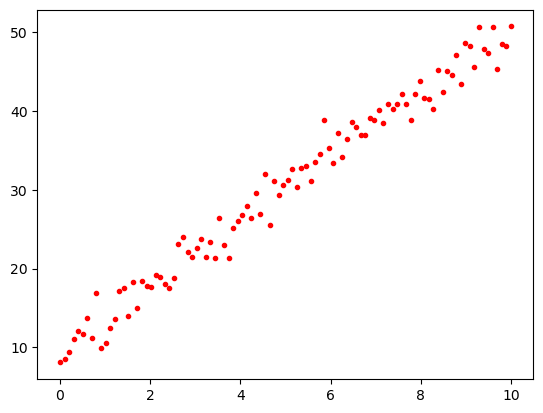

In [22]:
# In our synthetic data, we have w = 4 and b = 10
N = 100  # Number of training data points
x = np.linspace(0, 10, N)

t = 4 * x + 10 + npr.normal(0, 2, x.shape[0])
plt.plot(x, t, "r.")

x = torch.from_numpy(x)
t = torch.from_numpy(t)

In [23]:
# Initialize random parameters
params = {
    "w": torch.randn(1).requires_grad_(True),
    "b": torch.randn(1).requires_grad_(True),
}


def cost(params):
    y = params["w"] * x + params["b"]
    return (1 / N) * torch.sum(0.5 * (y - t) ** 2)


# Find the gradient of the cost function using pytorch
num_epochs = 1000  # Number of epochs of training
alpha = 0.01  # Learning rate

for i in range(num_epochs):
    # Evaluate the gradient of the current parameters stored in params
    loss = cost(params)
    loss.backward()

    if i % 100 == 0:
        print(f"i: {i:<5d} loss: {loss.item():.4f}")

    # Update parameters w and b
    with torch.no_grad():
        params["w"].data = params["w"] - alpha * params["w"].grad
        params["b"].data = params["b"] - alpha * params["b"].grad
        params["w"].grad.zero_()
        params["b"].grad.zero_()

print(params)

i: 0     loss: 553.8248
i: 100   loss: 8.4828
i: 200   loss: 5.7788
i: 300   loss: 4.1338
i: 400   loss: 3.1331
i: 500   loss: 2.5243
i: 600   loss: 2.1540
i: 700   loss: 1.9287
i: 800   loss: 1.7916
i: 900   loss: 1.7082
{'w': tensor([4.2171], requires_grad=True), 'b': tensor([8.9451], requires_grad=True)}


In [24]:
params

{'w': tensor([4.2171], requires_grad=True),
 'b': tensor([8.9451], requires_grad=True)}

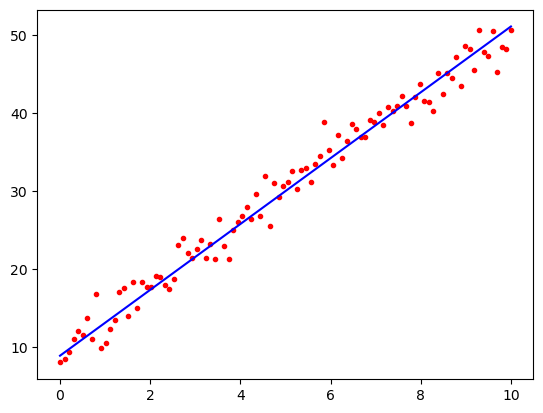

In [25]:
# Plot the training data again, together with the line defined by y = wx + b
# where w and b are our final learned parameters
plt.plot(x, t, "r.")
plt.plot(
    [0, 10],
    [params["b"].detach().numpy(), (params["w"] * 10 + params["b"]).detach().numpy()],
    "b-",
)

### Linear regression with a feature mapping

In this example we will fit a polynomial using linear regression with a polynomial feature mapping.
The target function is:

$$
t = x^4 - 10 x^2 + 10 x + \epsilon
$$

where $\epsilon \sim \mathcal{N}(0, 4)$.

This is an example of a _generalized linear model_, in which we perform a fixed nonlinear transformation of the inputs $\mathbf{x} = (x_1, x_2, \dots, x_D)$, and the model is still linear in the _parameters_. We can define a set of _feature mappings_ (also called feature functions or basis functions) $\phi$ to implement the fixed transformations.

In this case, we have $x \in \mathbb{R}$, and we define the feature mapping:
$$
\mathbf{\phi}(x) = \begin{pmatrix}\phi_0(x)\\ \phi_1(x) \\ \phi_2(x) \\ \phi_3(x) \\ \phi_4(x) \end{pmatrix} = \begin{pmatrix}1\\x\\x^2\\x^3\\x^4\\\end{pmatrix}
$$

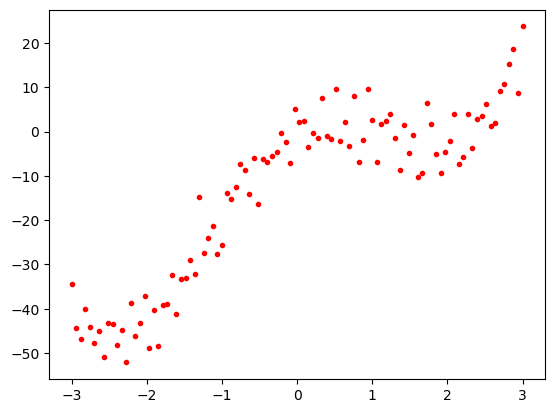

In [26]:
# Generate synthetic data
N = 100  # Number of data points
x = np.linspace(-3, 3, N)  # Generate N values linearly-spaced between -3 and 3
t = (
    x**4 - 10 * x**2 + 10 * x + npr.normal(0, 4, x.shape[0])
)  # Generate corresponding targets
plt.plot(x, t, "r.")  # Plot data points

t = torch.from_numpy(t).view(-1, 1)

In [27]:
M = 4  # Degree of polynomial to fit to the data (this is a hyperparameter)

feature_matrix = torch.tensor(
    [[item**i for i in range(M + 1)] for item in x], dtype=torch.float32
)

params = {
    "w": torch.randn(M + 1, 1).requires_grad_(True),
}
print(params["w"].shape)


def cost(params):
    y = torch.mm(feature_matrix, params["w"])
    return (1.0 / N) * torch.sum(0.5 * (y - t) ** 2)


# Compute the gradient of the cost function using Autograd


num_epochs = 1000
learning_rate = 0.001

# Manually implement gradient descent
for i in range(num_epochs):
    loss = cost(params)
    loss.backward()
    if i % 100 == 0:
        print(f"i: {i:<5d} loss: {loss.item():.4f}")
    with torch.no_grad():
        params["w"].data = params["w"] - learning_rate * params["w"].grad
        params["w"].grad.zero_()


# Print the final learned parameters.
print(params["w"])
w = params["w"].detach().cpu().numpy()

torch.Size([5, 1])
i: 0     loss: 579.9449
i: 100   loss: 78.6006
i: 200   loss: 63.1597
i: 300   loss: 51.9009
i: 400   loss: 43.6150
i: 500   loss: 37.4497
i: 600   loss: 32.8037
i: 700   loss: 29.2519
i: 800   loss: 26.4934
i: 900   loss: 24.3148
tensor([[-3.8460],
        [ 3.9821],
        [-5.8991],
        [ 0.9089],
        [ 0.5235]], requires_grad=True)


/var/folders/dj/k5kk5wk90vvcnb_wphpw490r0000gn/T/ipykernel_15900/1723298331.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.plot(x, np.dot(feature_matrix, w), "b-")


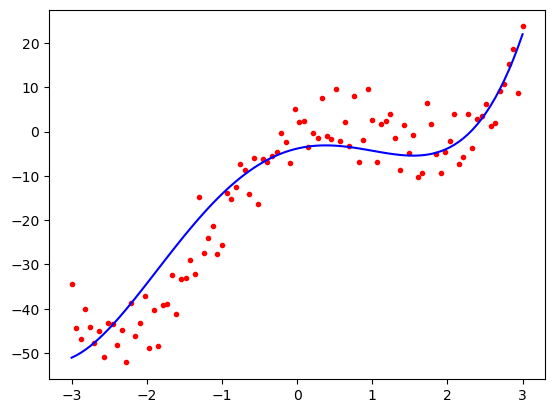

In [28]:
# Plot the original training data again, together with the polynomial we fit
plt.plot(x, t, "r.")
plt.plot(x, np.dot(feature_matrix, w), "b-")

### Neural net regression

In this example we will implement a (nonlinear) regression model using a neural network. To implement and train a neural net using Autograd, you only have to define the forward pass of the network and the loss function you wish to use; you do _not_ need to implement the _backward pass_ of the network. When you take the gradient of the loss function using `grad`, Autograd automatically computes computes the backward pass. It essentially executes the backpropagation algorithm implicitly.

![Neural Network Architecture for Regression](https://drive.google.com/uc?export=view&id=1iBNS40V_afm_Y1MUosDqeio0wbxgycfh)

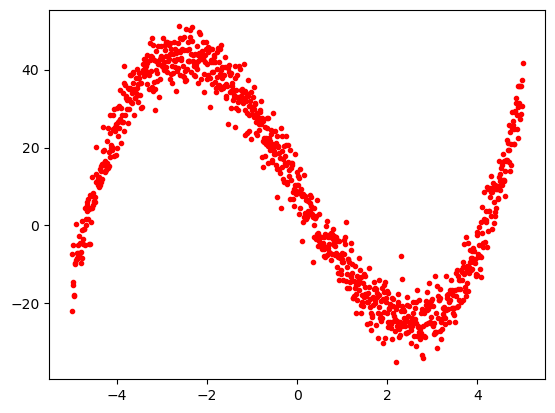

In [29]:
# Generate synthetic data
x = np.linspace(-5, 5, 1000)
t = x**3 - 20 * x + 10 + npr.normal(0, 4, x.shape[0])
plt.plot(x, t, "r.")

x = torch.from_numpy(x).float()
t = torch.from_numpy(t)

tensor(294.9556, dtype=torch.float64, grad_fn=<MulBackward0>)
i: 0     loss: 294.9556
i: 500   loss: 115.6264
i: 1000  loss: 76.3405
i: 1500  loss: 70.3700
i: 2000  loss: 67.0613
i: 2500  loss: 65.1220
i: 3000  loss: 63.8872
i: 3500  loss: 63.0808
i: 4000  loss: 62.5556
i: 4500  loss: 62.2048
i: 5000  loss: 61.9699
i: 5500  loss: 61.8097
i: 6000  loss: 61.7004
i: 6500  loss: 61.6258
i: 7000  loss: 61.5748
i: 7500  loss: 61.5412
i: 8000  loss: 61.5187
i: 8500  loss: 61.5037
i: 9000  loss: 61.4940
i: 9500  loss: 61.4874


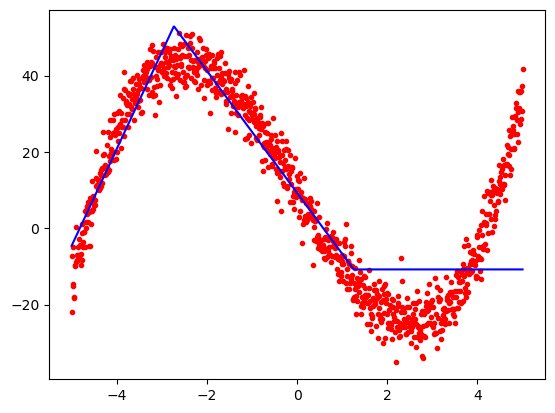

In [30]:
inputs = x.reshape(x.shape[-1], 1)

params = {
    "W1": torch.randn(1, 4).requires_grad_(True),
    "b1": torch.randn(4).requires_grad_(True),
    "W2": torch.randn(4, 4).requires_grad_(True),
    "b2": torch.randn(4).requires_grad_(True),
    "W3": torch.randn(4, 1).requires_grad_(True),
    "b3": torch.randn(1).requires_grad_(True),
}


# We can define an optimizer which takes care of updating parameters based on their gradient. We can use more complex optimizers like SGD+Momntum or Adam.
optimizer = torch.optim.SGD(
    params.values(), lr=0.0001, weight_decay=0.0001, momentum=0.9
)

# Pytorch also has implementation of wide range of activation functions such as: Tanh, ReLU, LeakyReLU, ...
nonlinearity = torch.nn.ReLU()


def predict(params, inputs):
    h1 = nonlinearity(torch.mm(inputs, params["W1"]) + params["b1"])
    h2 = nonlinearity(torch.mm(h1, params["W2"]) + params["b2"])
    output = torch.mm(h2, params["W3"]) + params["b3"]
    return output


def cost(params):
    output = predict(params, inputs)
    return (1.0 / inputs.shape[0]) * torch.sum(
        0.5 * (output.reshape(output.shape[0]) - t) ** 2
    )


print(cost(params))

num_epochs = 10000

for i in range(num_epochs):
    # Evaluate the gradient of the current parameters stored in params
    loss = cost(params)
    if i % 500 == 0:
        print(f"i: {i:<5d} loss: {loss.item():.4f}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

with torch.no_grad():
    final_y = predict(params, inputs)
    plt.plot(x, t, "r.")
    plt.plot(x, final_y, "b-")

## Neural network models

Unlike Tensorflow, we can define the graph on the fly. That is why it is more convenient to define a function in Python: we call the function as part of constructing the graph.

Let's now create a simple model for classifiying MNIST digits.

### MNIST classification

MNIST is a famous dataset containing hand-written digits. The training set contains 60k and the test set contains 10k images. Pytorch has built-in functions for downloading well-known datasets like MNIST.

In [31]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(
    "data", train=True, download=True, transform=transforms.ToTensor()
)

mnist_test = datasets.MNIST(
    "../data", train=False, download=True, transform=transforms.ToTensor()
)

In [32]:
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


Label:  9


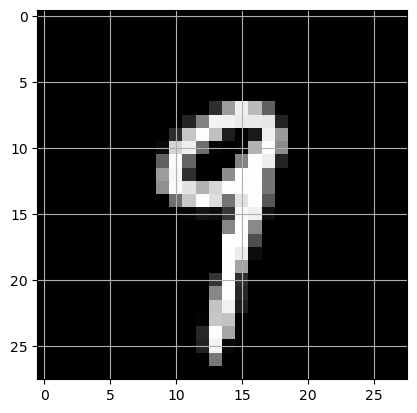

In [33]:
i = npr.randint(1, 50000)
example = mnist_train[i]
print("Label: ", example[1])
plt.imshow(example[0].reshape((28, 28)), cmap=plt.cm.gray)
plt.grid(None)

Pytorch's DataLoader is responsible for creating an iterator over the dataset.  

In [34]:
import torchvision
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST(
    "data", train=True, download=True, transform=transforms.ToTensor()
)

mnist_test = datasets.MNIST(
    "data", train=False, download=True, transform=transforms.ToTensor()
)

bs = 32
train_dl = DataLoader(mnist_train, batch_size=bs)
test_dl = DataLoader(mnist_test, batch_size=100)

dataiter = iter(train_dl)
images, labels = dataiter.next()
viz = torchvision.utils.make_grid(images, nrow=10, padding=2).numpy()
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.transpose(viz, (1, 2, 0)))
# ax.grid(None)

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

Using pytorch built-in function we can easily define any model like multi-layer perceptrons. After training, we just care about the average test accuracy, so let's write a function to compute the accuracy over test set.

In [35]:
def get_test_stat(model, dl, device):
    model.eval()
    cum_loss, cum_acc = 0.0, 0.0
    for i, (xb, yb) in enumerate(dl):
        xb = xb.to(device)
        yb = yb.to(device)

        xb = xb.view(xb.size(0), -1)
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = (torch.max(y_pred.data, 1)[1] == yb).sum()  # accuracy(y_pred, yb)
        cum_loss += loss.item() * len(yb)
        cum_acc += acc.item() * len(yb)
    cum_loss /= 10000
    cum_acc /= 10000
    model.train()
    return cum_loss, cum_acc

In [36]:
dim_x = 784
dim_h = 100
dim_out = 10

model = torch.nn.Sequential(
    torch.nn.Linear(dim_x, dim_h),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_h, dim_out),
)

learning_rate = 1e-2
epochs = 2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Using GPUs in PyTorch is pretty straightforward
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"

# we need to tell pytorch to move the model to gpu
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(epochs):
    print(epoch)
    for i, (xb, yb) in enumerate(train_dl):

        # We also need to transfer the data to the target device
        xb = xb.to(device)
        yb = yb.to(device)
        xb = xb.view(xb.size(0), -1)

        # Forward pass
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)

        # Backward pass
        model.zero_grad()  # Zero out the previous gradient computation
        loss.backward()  # Compute the gradient
        optimizer.step()  # Use the gradient information to make a step

    test_loss, test_acc = get_test_stat(model, test_dl, device)
    print("Test loss: {}  Test acc: {}".format(test_loss, test_acc))

0
Test loss: 0.41697128385305404  Test acc: 88.78
1
Test loss: 0.3296788824349642  Test acc: 90.72


### Dynamic network

To showcase the power of PyTorch dynamic graphs, we will implement a very strange model: a fully-connected ReLU network that on each forward pass randomly chooses a number between 1 and 4 and has that many hidden layers, reusing the same weights multiple times to compute the innermost hidden layers.

By Justin Johnson https://github.com/jcjohnson/pytorch-examples/blob/master/nn/dynamic_net.py

In [37]:
import random


class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x, verbose=False):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.
        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.
        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        n_layers = random.randint(0, 3)
        if verbose:
            print("The number of layers for this run is", n_layers)
            # print(h_relu)
        for _ in range(n_layers):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
            if verbose:
                pass
                # print(h_relu)
        y_pred = self.output_linear(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10, 1

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = torch.randn(N, D_in)
y = torch.randn(N, D_out).requires_grad_(False)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(50):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 10 == 0:
        print(t, loss.data.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 72.53105926513672
10 54.949920654296875
20 67.36945343017578
30 66.8979263305664
40 51.94204330444336


### CIFAR10 classification

We will finish with an example on CIFAR10, highlighting the importance of applying transformations to your inputs. Example is lifted from:

https://github.com/uoguelph-mlrg/Cutout/blob/master/train.py

In [38]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
def get_data(data_normalize=False, data_augment=False):
    train_transform = transforms.Compose([])
    test_transform = transforms.Compose([])

    if data_augment:
        train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
        train_transform.transforms.append(transforms.RandomHorizontalFlip())

    train_transform.transforms.append(transforms.ToTensor())
    test_transform.transforms.append(transforms.ToTensor())

    if data_normalize:
        normalize = transforms.Normalize(
            mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
            std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
        )
        train_transform.transforms.append(normalize)
        test_transform.transforms.append(normalize)

    train_dataset = datasets.CIFAR10(
        root="data/", train=True, transform=train_transform, download=True
    )

    test_dataset = datasets.CIFAR10(
        root="data/", train=False, transform=test_transform, download=True
    )
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2
    )
    return train_loader, test_loader


def test(net, loader):
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.0
    total = 0.0
    for images, labels in loader:
        with torch.no_grad():
            pred = net(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = correct / total
    net.train()
    return val_acc

In [40]:
def train_model(train_loader, test_loader, epochs=5):

    net = Net()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    train_accs = []
    test_accs = []

    net.train()

    for epoch in range(epochs):
        print(epoch)

        xentropy_loss_avg = 0.0
        correct = 0.0
        total = 0.0

        for i, (images, labels) in enumerate(train_loader):

            net.zero_grad()
            pred = net(images)
            xentropy_loss = criterion(pred, labels)
            xentropy_loss.backward()
            optimizer.step()

            xentropy_loss_avg += xentropy_loss.item()

            # Calculate running average of accuracy
            pred = torch.max(pred.data, 1)[1]
            total += labels.size(0)
            correct += (pred == labels.data).sum().item()
            accuracy = correct / total

        test_acc = test(net, test_loader)
        print("Test acc: ", test_acc)
        train_accs.append(accuracy)
        test_accs.append(test_acc)
    return train_accs, test_accs

In [41]:
train_loader, test_loader = get_data(data_augment=False, data_normalize=False)
train_accs, test_accs = train_model(train_loader, test_loader, epochs=3)

100%|██████████| 170M/170M [06:35<00:00, 431kB/s]  


0
Test acc:  0.1202
1
Test acc:  0.1
2
Test acc:  0.1


In [42]:
train_loader, test_loader = get_data(data_augment=False, data_normalize=True)
normalize_train_accs, normalize_test_accs = train_model(
    train_loader, test_loader, epochs=3
)

0
Test acc:  0.323
1
Test acc:  0.433
2
Test acc:  0.4499


/var/folders/dj/k5kk5wk90vvcnb_wphpw490r0000gn/T/ipykernel_15900/2084687046.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


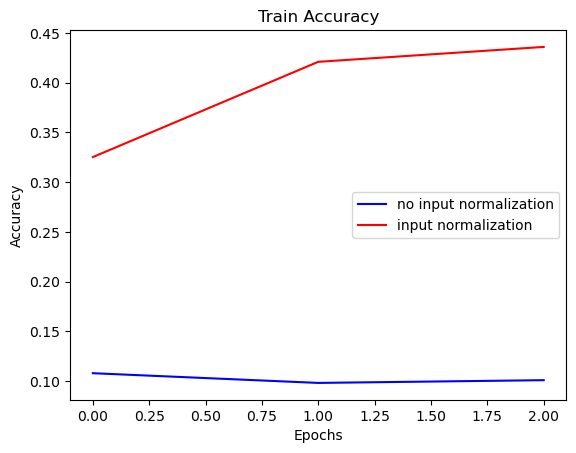

In [43]:
fig, ax = plt.subplots()
epochs = 3
ax.plot(range(epochs), train_accs, c="blue", label="no input normalization")
ax.plot(range(epochs), normalize_train_accs, c="red", label="input normalization")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Train Accuracy")
fig.show()